# Configuração

In [1]:
# Imports
import numpy as np
np.random.seed(0)
from multiprocessing import cpu_count
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import copy

# Config
tf.random.set_seed(0)
matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
nproc = cpu_count()

In [2]:
!nvidia-smi -L

GPU 0: Tesla P4 (UUID: GPU-e2d35cc2-ac07-3a71-46da-3d0994fa4bab)


In [3]:
# Load data
mnist = tf.keras.datasets.mnist
# Train-test split
(x, y),(x_test, y_test) = mnist.load_data()
# Reshape and normalization
x, x_test = x.reshape(x.shape[0], 28, 28, 1), x_test.reshape(x_test.shape[0], 28, 28, 1)
x, x_test = x / 255.0, x_test / 255.0

In [4]:
# Shuffle and create val set
N = len(x)
new_order = np.random.permutation(N)
x = x[new_order,:]
y = y[new_order]
tr_pct = 0.8
div_idx = int(tr_pct*N)
x_train = x[:div_idx, :]
x_val = x[div_idx:, :]
y_train = y[:div_idx]
y_val = y[div_idx:]

# Modelo exemplo

In [5]:
# Baseline code (Prof. Von Zuben)
acc, loss = 0, 0
for _ in range(3):
    # Average 3 times for better results
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    model.fit(x, y, epochs=5, verbose=0)

    loss_, acc_ = model.evaluate(x_test, y_test)
    loss += loss_
    acc += acc_
print("Acc:", acc/3, "Loss:", loss/3)

313/313 [==============================] - 1s 2ms/step - loss: 0.0261 - accuracy: 0.9918
Acc: 0.9915999968846639 Loss: 0.027167538180947304


In [6]:
model.build(x.shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

# Modelo concorrente

Para criar um modelo com desempenho superior, foram testadas algumas configurações para um treinamento com o mesmo número de épocas (5) e um número igual ou menor de parâmtros. Na notação utilizada daqui para frente temos "\<X>C\<Y>S\<Z>" para denominar camadas convolucionais com \<X> kerneis \<Y>x\<Y> e stride \<Z>x\<Z> (exemplo 32C3S2 é uma camada com 32 kerneis (3x3) e stride (2x2)) se o número de stride é omitido ele é (1x1). Para camadas de pooling "P\<X>" é uma camada de max pooling \<X>x\<X>:

In [7]:
n_output_neurons = 10
epochs = 5
bs = 128
opt=tf.keras.optimizers.Adam()
fn=tf.keras.losses.SparseCategoricalCrossentropy()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
params = {
    'architecture': [
                     '32C3-P2-64C3-P2-128',
                     '32C5-P2-64C5-P2-128',
                     '32C3-32C3-32C5S2-128',
                     '64C3-64C3-64C5S2-128',
    ],
}

In [8]:
def create_cnn(architecture,
               n_output_neurons):
    model = tf.keras.Sequential()
    for layer in architecture.split('-'):
        if layer[0].isdigit():
            if layer.isdigit():
                n = int(layer)
                model.add(tf.keras.layers.Flatten())
                model.add(tf.keras.layers.Dense(n))
            else:
                end = None
                if 'S' in layer:
                    stride = int(layer[layer.find('S')+1:end])
                    end = layer.find('S')
                else:
                    stride = 1
                if 'C' in layer:
                    k = int(layer[layer.find('C')+1:end])
                    end = layer.find('C')
                else:
                    k = 1
                n = int(layer[:end])
                model.add(tf.keras.layers.Conv2D(n, (k, k), (stride, stride)))
        elif layer[0] == 'P':
            p = int(layer[1:])
            model.add(tf.keras.layers.MaxPool2D(pool_size=(p,p)))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(n_output_neurons, tf.nn.softmax))
    return model

## Busca por hiperparâmetros

In [9]:
# Hyperparameters search
best_loss = np.float('inf')
for arch in params['architecture']:
    model = create_cnn(arch, n_output_neurons)
    model.compile(optimizer=opt,
                    loss=fn,
                    metrics='accuracy')
    history = model.fit(x_train, y_train, epochs=epochs, verbose=0,
                callbacks=[callback,], batch_size=bs, shuffle=True)
    print("Arquitetura:", arch+'-'+str(n_output_neurons))
    loss, acc = model.evaluate(x_val, y_val)
    if loss < best_loss:
        best_loss = loss
        best_arch = arch
        best_history = history

Arquitetura: 32C3-P2-64C3-P2-128-10
375/375 [==============================] - 1s 2ms/step - loss: 0.0332 - accuracy: 0.9902
Arquitetura: 32C5-P2-64C5-P2-128-10
375/375 [==============================] - 1s 2ms/step - loss: 0.0289 - accuracy: 0.9912
Arquitetura: 32C3-32C3-32C5S2-128-10
375/375 [==============================] - 1s 2ms/step - loss: 0.0374 - accuracy: 0.9894
Arquitetura: 64C3-64C3-64C5S2-128-10
375/375 [==============================] - 1s 3ms/step - loss: 0.0445 - accuracy: 0.9864


In [10]:
best_model = create_cnn(best_arch, n_output_neurons)
best_model.build(x.shape)
best_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (60000, 24, 24, 32)       832       
_________________________________________________________________
batch_normalization_18 (Batc (60000, 24, 24, 32)       128       
_________________________________________________________________
activation_18 (Activation)   (60000, 24, 24, 32)       0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (60000, 12, 12, 32)       0         
_________________________________________________________________
batch_normalization_19 (Batc (60000, 12, 12, 32)       128       
_________________________________________________________________
activation_19 (Activation)   (60000, 12, 12, 32)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (60000, 8, 8, 64)        

## Treino

O modelo escolhido tem aproximadamente 10 vezes menos parâmetros (185866 ao invés de 1199882 do modelo exemplo) e desenpenho próximo na validação. Agora treinaremos 5 épocas em todo o conjunto de treino para a avaliação no conjunto de teste:

In [11]:
# Average 3 times for better results
acc, loss = 0, 0
for _ in range(3):
    model = create_cnn(best_arch, n_output_neurons)
    model.compile(optimizer=opt,
                   loss=fn,
                   metrics='accuracy')
    best_history = model.fit(x, y, epochs=epochs, verbose=0,
                              callbacks=[callback,], batch_size=bs, shuffle=True)

    loss_, acc_ = model.evaluate(x_test, y_test, batch_size=bs)
    loss += loss_
    acc += acc_
print("Acc:", acc/3, "Loss:", loss/3)

79/79 [==============================] - 0s 3ms/step - loss: 0.0221 - accuracy: 0.9931
Acc: 0.9925666650136312 Loss: 0.022967244187990826


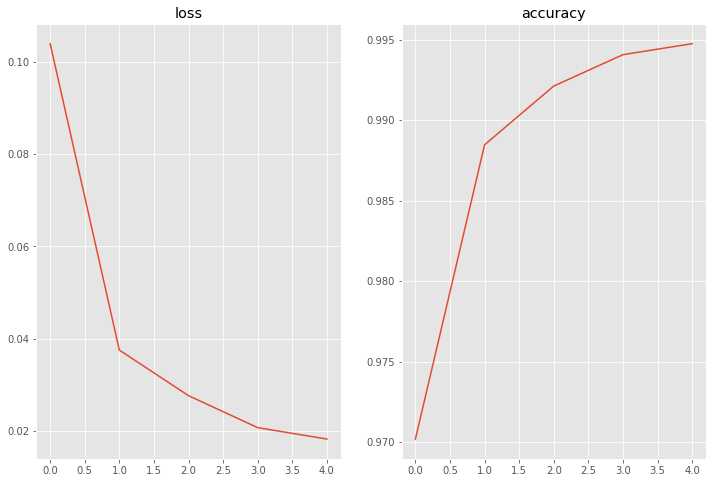

In [12]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,2,1)
plt.plot(best_history.history['loss'])
plt.title('loss')
ax = fig.add_subplot(1,2,2)
plt.plot(best_history.history['accuracy'])
plt.title("accuracy")
plt.show()

Pela curva de aprendizado acima é possível perceber que o modelo tinha um movimento de crescimento de acurácia na quinta época, podemos testar o treinamento por mais épocas:

In [13]:
# Average 3 times for better results
acc, loss = 0, 0
for _ in range(3):
    model = create_cnn(best_arch, n_output_neurons)
    model.compile(optimizer=opt,loss=fn,metrics=['accuracy'])
    best_history = model.fit(x, y, epochs=20, verbose=0,
                callbacks=[callback,], batch_size=bs, shuffle=True)

    loss_, acc_ = model.evaluate(x_test, y_test)
    loss += loss_
    acc += acc_
print("Acc:", acc/3, "Loss:", loss/3)

313/313 [==============================] - 1s 2ms/step - loss: 0.0282 - accuracy: 0.9925
Acc: 0.9931333263715109 Loss: 0.025865764046708744


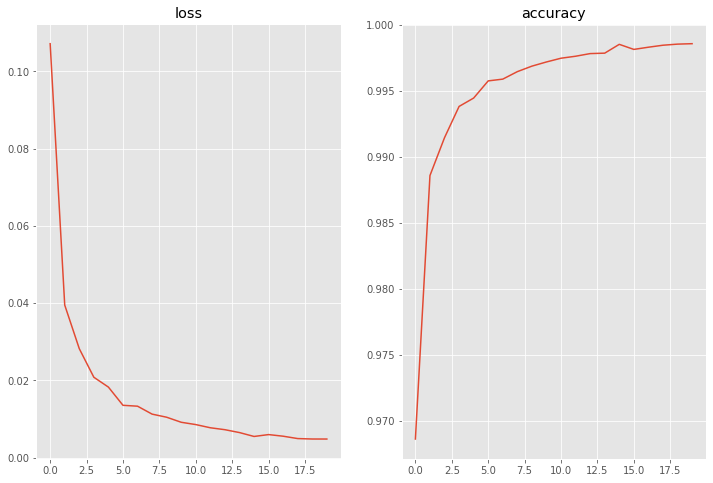

In [14]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,2,1)
plt.plot(best_history.history['loss'])
plt.title('loss')
ax = fig.add_subplot(1,2,2)
plt.plot(best_history.history['accuracy'])
plt.title("accuracy")
plt.show()

# Resultados

O modelo final possúi desempenho superior tanto na perda como na acurácia, mesmo possuindo significativamente menos parâmetros para serem treinados.

Modelo | Camadas | Outros | N. Parâmetros | Épocas | Entropia Cruzada | Acurácia
--- | --- | --- | --- | --- | ---| ---
1 | 32C3-P2-64C3-P2-128-10 | Dropout | 1,199,882  | 5 | 0.0271 | 0.9916
2 | 32C5-P2-64C5-P2-128-10 | Dropout, BatchNorm | 185,866 | 5 | 0.0229 | 0.9926
3 | 32C5-P2-64C5-P2-128-10 | Dropout, BatchNorm | 185,866 | 20 | **0.0258** | **0.9931**

Em comparação às técnicas exploradas anteriormente, esta solução é de longe a que obtém maior sucesso na tarefa de classificação. Isto se dá, pois a complexidade dos modelos cresceram pouco a pouco: o primeiro classificador linear possuia solução fechada, mostrando a melhor solução encontrável por um classificador linear treinado com os dados que foi treinado. Depois disso, utilizamos uma ELM, linear nos parâmtros, porém com capacidade de efetuar relações não lineares provenientes da camada intermediária (apesar de pesos aleatórios, esta camada e a função de ativação não-linear, permitem que a entrada para a camada final, já contenha características, assim, aumentando a complexidade do classificador).

Depois empregamos técnicas de aprendizado profundo (multiplas camadas treinadas com otimização de primeira ordem, dropout para regularizar e ao mesmo tempo englobar múltiplos "votos" na classificação final, etc.) que são capazes de aproximar qualquer função. Aqui estaríamos no nível mais elevado de complexidade o suficiente para a tarefa de classificação, mas a solução por retropropagação de erro e gradiente descendente não é fechada. Desta forma, ao empregar redes convolucionais - que se mostraram extremamente capazes para extração de característica de imagens - conseguimos elevar ainda mais a taxa de acerto (~99%), sendo esta a melhor solução dentre as exploradas.

Hipóteses do porque do desempenho superior das redes convolucionais nesta tarefa podem ser levantadas: o stride e o max-pooling eliminaria pequenas diferenças de translação, o kernel (formado por parâmetros compartilhados) e o emprego da convolução nos permite extrair informações comuns a quaisquer imagens como informações de bordas, dentre outras. Abaixo está a tabela comparativa de todos os classificadores

Modelo |  Erro (MSE ou entropia cruzada) | Acurácia
--- | --- | --- 
Perceptron (classificador linear) | 0.0388 | 0.8642
Máquina de aprendizado extremo (ELM) | 0.0215  | 0.9446
Perceptron de múltiplas camadas (MLP) | 0.0582 | 0.9829
Rede neural convolucional (CNN) | 0.0258 | 0.9931